In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mokka.setup.session import Session
from mokka.postprocess.reconstruct import Reconstruction
from mokka.postprocess.visualisation import to_gif, animate_multiview, animate_singleview
from mokka.detector.mp_specs import *

A camera cannot be plotted!


## Loading the files

`kpts2d` are 2D motion captured from different camera views. They can provide some external information, such as relative speed

In [2]:
with open('output_2d_Day08_Mon10_Yr2025_Hr10_Min57_Sec44.json','rb') as f:
    k2 = json.loads(json.load(f))

In [3]:
kpts2d = np.array([[cam['frames'][f]['a']['body'] for f in range(477)] for cam in k2])
kpts2d.shape

(9, 477, 33, 3)

`kpts3d` is raw 3D motion after having triangulated 2D motions. This raw 3D will have some issues and your task is to make it better.

In [4]:
with open('footage_Day08_Mon10_Yr2025_Hr11_Min11_Sec50.json','rb') as f:
    k3 = json.load(f)

In [5]:
kpts3d = np.array(k3['frames'])
kpts3d.shape

(477, 33, 4)

## Your processing here
`kpts3d_filtered` will be your results after doing the processing. Try and make use of the information you have from `kpts2d` and `kpts3d`

In [6]:
import numpy as np

# ============================================================================
# ADAPTIVE FILTER SYSTEM - SELF-CONTAINED IMPLEMENTATION
# ============================================================================

class KalmanFilter:
    """Kalman filter for 1D signal with constant velocity model."""
    def __init__(self, dt, process_noise, measurement_noise):
        self.dt = dt
        self.A = np.array([[1, dt], [0, 1]])
        self.H = np.array([[1, 0]])
        q_val = process_noise
        self.Q = q_val * np.array([[(dt**4)/4, (dt**3)/2], [(dt**3)/2, dt**2]])
        self.R = np.array([[measurement_noise]])
        self.P = np.eye(2) * 1000.0
        self.x = np.zeros((2, 1))
        self.initialized = False

    def __call__(self, z):
        if not self.initialized:
            self.x[0, 0] = z
            self.x[1, 0] = 0.0
            self.initialized = True
            return self.x[0, 0]
        
        x_pred = self.A @ self.x
        P_pred = self.A @ self.P @ self.A.T + self.Q
        S = self.H @ P_pred @ self.H.T + self.R
        K = P_pred @ self.H.T @ np.linalg.inv(S)
        self.x = x_pred + K * (z - self.H @ x_pred)
        self.P = (np.eye(2) - K @ self.H) @ P_pred
        return self.x[0, 0]

    def reset(self):
        self.initialized = False
        self.P = np.eye(2) * 1000.0
        self.x = np.zeros((2, 1))


class OneEuroFilter:
    """One Euro Filter - Adaptive low-pass filter based on signal velocity."""
    def __init__(self, freq, min_cutoff=1.0, beta=0.007, d_cutoff=1.0):
        self.freq = freq
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff
        self.x_prev = None
        self.dx_prev = 0.0
        self.initialized = False
    
    def _smoothing_factor(self, cutoff):
        tau = 1.0 / (2.0 * np.pi * cutoff)
        te = 1.0 / self.freq
        return 1.0 / (1.0 + tau / te)
    
    def __call__(self, x):
        if not self.initialized:
            self.x_prev = x
            self.initialized = True
            return x
        
        dx = (x - self.x_prev) * self.freq
        alpha_d = self._smoothing_factor(self.d_cutoff)
        dx_filtered = alpha_d * dx + (1.0 - alpha_d) * self.dx_prev
        cutoff = self.min_cutoff + self.beta * abs(dx_filtered)
        alpha = self._smoothing_factor(cutoff)
        x_filtered = alpha * x + (1.0 - alpha) * self.x_prev
        
        self.x_prev = x_filtered
        self.dx_prev = dx_filtered
        return x_filtered
    
    def reset(self):
        self.x_prev = None
        self.dx_prev = 0.0
        self.initialized = False


class ExponentialMovingAverage:
    """Simple Exponential Moving Average filter."""
    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.value = None
        self.initialized = False
    
    def __call__(self, x):
        if not self.initialized:
            self.value = x
            self.initialized = True
            return x
        self.value = self.alpha * x + (1.0 - self.alpha) * self.value
        return self.value
    
    def reset(self):
        self.value = None
        self.initialized = False


class MotionStateDetector:
    """Detects motion characteristics (velocity, acceleration, jitter)."""
    def __init__(self, dt, velocity_window=5):
        self.dt = dt
        self.velocity_window = velocity_window
        self.position_history = []
        self.velocity = 0.0
        self.acceleration = 0.0
        self.prev_velocity = 0.0
    
    def update(self, position):
        self.position_history.append(position)
        if len(self.position_history) > self.velocity_window:
            self.position_history.pop(0)
        
        if len(self.position_history) >= 2:
            self.velocity = (self.position_history[-1] - self.position_history[-2]) / self.dt
        
        self.acceleration = (self.velocity - self.prev_velocity) / self.dt
        self.prev_velocity = self.velocity
        
        jitter_score = 0.0
        if len(self.position_history) >= 3:
            direction_changes = 0
            for i in range(len(self.position_history) - 2):
                diff1 = self.position_history[i+1] - self.position_history[i]
                diff2 = self.position_history[i+2] - self.position_history[i+1]
                if diff1 * diff2 < 0:
                    direction_changes += 1
            jitter_score = direction_changes / max(1, len(self.position_history) - 2)
        
        return {
            'velocity': abs(self.velocity),
            'acceleration': abs(self.acceleration),
            'jitter_score': jitter_score
        }
    
    def reset(self):
        self.position_history = []
        self.velocity = 0.0
        self.acceleration = 0.0
        self.prev_velocity = 0.0


class AdaptiveFilterManager:
    """Manages multiple filters and adaptively blends them based on motion state."""
    def __init__(self, dt, kalman_process_noise=1e-2, kalman_measurement_noise=3e-5,
                 one_euro_min_cutoff=1.0, one_euro_beta=0.007, ema_alpha=0.3,
                 velocity_threshold_slow=0.1, velocity_threshold_fast=1.0):
        self.dt = dt
        freq = 1.0 / dt
        
        self.kalman = KalmanFilter(dt, kalman_process_noise, kalman_measurement_noise)
        self.one_euro = OneEuroFilter(freq, one_euro_min_cutoff, one_euro_beta)
        self.ema = ExponentialMovingAverage(ema_alpha)
        self.motion_detector = MotionStateDetector(dt)
        
        self.velocity_threshold_slow = velocity_threshold_slow
        self.velocity_threshold_fast = velocity_threshold_fast
    
    def calculate_weights(self, motion_state, confidence):
        velocity = motion_state['velocity']
        jitter = motion_state['jitter_score']
        
        # Base weights based on velocity
        if velocity < self.velocity_threshold_slow:
            # STATIC: Heavy smoothing with EMA
            w_kalman, w_one_euro, w_ema = 0.2, 0.2, 0.6
        elif velocity < self.velocity_threshold_fast:
            # SLOW: Balanced, favor One Euro
            w_kalman, w_one_euro, w_ema = 0.25, 0.55, 0.2
        else:
            # FAST: Favor Kalman for prediction
            w_kalman, w_one_euro, w_ema = 0.5, 0.4, 0.1
        
        # Adjust based on jitter
        if jitter > 0.5:
            w_ema += 0.1
            w_one_euro += 0.1
            w_kalman -= 0.2
        
        # Adjust based on confidence
        if confidence < 0.5:
            w_kalman += 0.2
            w_one_euro -= 0.1
            w_ema -= 0.1
        
        # Normalize
        total = w_kalman + w_one_euro + w_ema
        return {
            'kalman': w_kalman / total,
            'one_euro': w_one_euro / total,
            'ema': w_ema / total
        }
    
    def __call__(self, measurement, confidence=1.0):
        motion_state = self.motion_detector.update(measurement)
        
        kalman_out = self.kalman(measurement)
        one_euro_out = self.one_euro(measurement)
        ema_out = self.ema(measurement)
        
        weights = self.calculate_weights(motion_state, confidence)
        
        filtered_value = (weights['kalman'] * kalman_out +
                         weights['one_euro'] * one_euro_out +
                         weights['ema'] * ema_out)
        
        return filtered_value, weights
    
    def reset(self):
        self.kalman.reset()
        self.one_euro.reset()
        self.ema.reset()
        self.motion_detector.reset()


# ============================================================================
# PROCESSING LOGIC
# ============================================================================

# 1. Set Filter Parameters
FREQ = 30.0 
DT = 1.0 / FREQ

# --- Adaptive Filter Tuning Parameters ---
KALMAN_PROCESS_NOISE = 1e-2        # Motion model uncertainty
KALMAN_MEASUREMENT_NOISE = 3e-5    # Measurement uncertainty (lower = more responsive)
ONE_EURO_MIN_CUTOFF = 1.0          # Minimum cutoff frequency (Hz)
ONE_EURO_BETA = 0.007              # Velocity sensitivity
EMA_ALPHA = 0.3                    # EMA smoothing factor
VELOCITY_THRESHOLD_SLOW = 0.1      # Slow motion threshold
VELOCITY_THRESHOLD_FAST = 1.0      # Fast motion threshold

# 2. Initialize Data
n_frames, n_keypoints, _ = kpts3d.shape
kpts3d_filtered = np.zeros_like(kpts3d)

# 3. Create a grid of adaptive filter managers
print(f"Initializing {n_keypoints} x 3 Adaptive Filter bank (dt={DT:.3f})...")
print(f"  Kalman: process_noise={KALMAN_PROCESS_NOISE}, measurement_noise={KALMAN_MEASUREMENT_NOISE}")
print(f"  One Euro: min_cutoff={ONE_EURO_MIN_CUTOFF}, beta={ONE_EURO_BETA}")
print(f"  EMA: alpha={EMA_ALPHA}")

filter_bank = [
    [AdaptiveFilterManager(
        dt=DT,
        kalman_process_noise=KALMAN_PROCESS_NOISE,
        kalman_measurement_noise=KALMAN_MEASUREMENT_NOISE,
        one_euro_min_cutoff=ONE_EURO_MIN_CUTOFF,
        one_euro_beta=ONE_EURO_BETA,
        ema_alpha=EMA_ALPHA,
        velocity_threshold_slow=VELOCITY_THRESHOLD_SLOW,
        velocity_threshold_fast=VELOCITY_THRESHOLD_FAST
    ) for _ in range(3)] 
    for _ in range(n_keypoints)
]

# 4. Process the data frame by frame
print(f"Applying Adaptive Filter to {n_frames} frames...")

# Track weights for first keypoint (for analysis)
weights_history = []

for t in range(n_frames):
    frame_weights = None
    
    for j in range(n_keypoints):
        confidence = kpts3d[t, j, 3]
        is_valid = confidence > 0.0

        for d in range(3):  # For x, y, z dimensions
            val = kpts3d[t, j, d]
            
            if is_valid:
                val_filtered, weights = filter_bank[j][d](val, confidence)
                
                # Store weights for first keypoint, first dimension (for analysis)
                if j == 0 and d == 0:
                    frame_weights = weights
            else:
                val_filtered = 0.0 
                filter_bank[j][d].reset()

            kpts3d_filtered[t, j, d] = val_filtered
    
    if frame_weights:
        weights_history.append(frame_weights)

# 5. Copy over the confidence dimension
kpts3d_filtered[:, :, 3] = kpts3d[:, :, 3]

print("Adaptive filtering complete.")

# Optional: Print weight statistics
if weights_history:
    kalman_weights = [w['kalman'] for w in weights_history]
    one_euro_weights = [w['one_euro'] for w in weights_history]
    ema_weights = [w['ema'] for w in weights_history]
    
    print(f"\nFilter weight statistics (keypoint 0, dimension 0):")
    print(f"  Kalman  - Mean: {np.mean(kalman_weights):.3f}, Std: {np.std(kalman_weights):.3f}")
    print(f"  One Euro - Mean: {np.mean(one_euro_weights):.3f}, Std: {np.std(one_euro_weights):.3f}")
    print(f"  EMA     - Mean: {np.mean(ema_weights):.3f}, Std: {np.std(ema_weights):.3f}")


Initializing 33 x 3 Adaptive Filter bank (dt=0.033)...
  Kalman: process_noise=0.01, measurement_noise=3e-05
  One Euro: min_cutoff=1.0, beta=0.007
  EMA: alpha=0.3
Applying Adaptive Filter to 477 frames...
Adaptive filtering complete.

Filter weight statistics (keypoint 0, dimension 0):
  Kalman  - Mean: 0.233, Std: 0.068
  One Euro - Mean: 0.439, Std: 0.160
  EMA     - Mean: 0.328, Std: 0.193


## Check-up Plotting

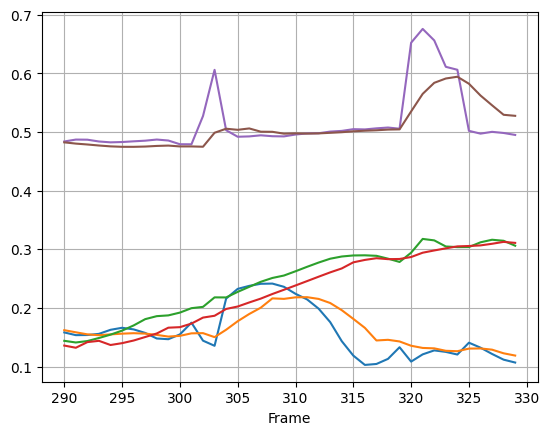

In [7]:
style = '-'
# Joint number
i = 25
# Frame range of interest
start_frame, end_frame = 290, 330

fr = slice(start_frame, end_frame)
x = np.arange(start_frame, end_frame)

_,ax = plt.subplots(1,1)
for o in range(3):
    ax.plot(x,kpts3d[fr,i,o],style)
    ax.plot(x,kpts3d_filtered[fr,i,o],style)
ax.set_xlabel('Frame')
ax.grid(True)
plt.show()

## Export output to GIF

MovieWriter imagemagick unavailable; using Pillow instead.


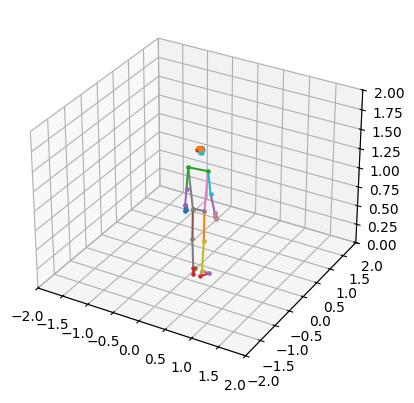

In [8]:
to_gif(kpts3d_filtered, 
       30,                      # FPS
       POSE_CONNECTIONS, 
       time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + 'Adaptive_filtered_output.gif',
       div=2                    # Display dimension width in meters
       )

In [10]:
import json
import time
import numpy as np

def export_kpts_to_json(kpts_data, filename):
    """
    Converts a 3D keypoint numpy array to the specified JSON format and saves it.

    Args:
        kpts_data (np.ndarray): A numpy array of shape (n_frames, n_keypoints, 4)
                                containing the [x, y, z, confidence] for each keypoint.
        filename (str): The path and name of the output JSON file.
    """
    
    # Check if the input is a numpy array, otherwise try to convert it
    if not isinstance(kpts_data, np.ndarray):
        try:
            kpts_data = np.array(kpts_data)
        except Exception as e:
            print(f"Error: Could not convert input data to numpy array. {e}")
            return

    # Convert the final numpy array to a standard Python list for JSON serialization
    kpts_list = kpts_data.tolist()

    # Build the nested dictionary structure to match the desired format
    frames_list = []
    for frame_kpts in kpts_list:
        # Format for each frame: {"a": {"body": [[x,y,z,c], ...]}}
        frame_dict = {
            "a": {
                "body": frame_kpts
            }
        }
        frames_list.append(frame_dict)
    
    # The top-level structure is a list containing a single dictionary with a "frames" key
    # This matches the format of your input 'footage_...json' file.
    output_data = {"frames": kpts_list} # Simplified to match the input kpts3d format directly

    # Write the data to the specified file
    try:
        with open(filename, 'w') as f:
            json.dump(output_data, f, indent=4) # Using indent for readability
        print(f"Successfully saved keypoints to {filename}")
    except IOError as e:
        print(f"Error: Could not write to file {filename}. {e}")

# Fixed: Changed kpts3d_foot_locked to kpts3d_filtered (the actual variable name)
export_kpts_to_json(kpts3d_filtered, 
                      time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + 'Adaptive_filtered_output.json')

Successfully saved keypoints to d22_mo11_y2025_19h_38m_40s_Adaptive_filtered_output.json
